In [1]:
from google.cloud import bigquery
import os
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from tabulate import tabulate

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "json_key_cloud.json"
client = bigquery.Client()

In [3]:
QUERY4 = ("""
with data as(
select unique_session_id, total_revenue, date,
	count(total_revenue) over (partition by date) as count,
	avg(total_revenue) over (partition by date) as avg,
	PERCENTILE_CONT(total_revenue, 0.5) OVER(partition by date) as median,
	stddev_samp(total_revenue) over(partition by date) as sko,
	min(total_revenue) over (partition by date) as min,
	max(total_revenue) over (partition by date) as max,
from
(
    select *
from
(
	select * ,
stddev_samp(logtar) over(partition by country) as sko,
avg(logtar) over(partition by country) as avg
from
  (
  SELECT
      CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
      totals.totalTransactionRevenue/1e6 AS total_revenue,
      log(totals.totalTransactionRevenue/1e6) as logtar,
      date, geoNetwork.country as country
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
      _TABLE_SUFFIX BETWEEN '20170601' AND '20170731'
      AND totals.totalTransactionRevenue IS NOT NULL
      AND geoNetwork.country = 'United States'
  ) as source_data
) as before_cut
WHERE abs(logtar - avg) < 3.09*sko
   ) as pre_data
)

select * from
(
select distinct date, count, avg, median, min, max, sko, sko/avg as koef_var from data
) as finalyze
order by date
""")

In [4]:
query_job = client.query(QUERY4)
rows = query_job.result()

In [5]:
time_dynamic = [{'date':i.date,'median':round(float(i.median),2),'koef var':round(float(i.koef_var),4),'count':i.count} for i in rows]
columns = tuple(time_dynamic[0].keys())
print(columns)

('date', 'median', 'koef var', 'count')


In [6]:
print("{:<10} {:<10} {:<10} {:<10}".format(columns[0],columns[1],columns[2],columns[3]))
for i in time_dynamic:
    print("{:<10} {:<10} {:<10} {:<10}".format(i.get(columns[0]), i.get(columns[1]), i.get(columns[2]), i.get(columns[3])))

date       median     koef var   count     
20170601   59.28      0.9703     34        
20170602   52.27      1.8589     36        
20170603   31.48      1.4971     15        
20170604   34.58      1.7515     13        
20170605   60.58      1.357      35        
20170606   45.61      1.0102     27        
20170607   53.0       0.9638     34        
20170608   31.04      1.703      24        
20170609   67.67      0.9607     34        
20170610   45.59      0.6629     10        
20170611   36.66      0.9438     23        
20170612   59.36      1.6622     57        
20170613   56.06      1.0075     46        
20170614   83.95      1.266      42        
20170615   48.04      1.6788     31        
20170616   57.07      1.5951     33        
20170617   40.99      2.6427     17        
20170618   49.17      1.7912     24        
20170619   38.39      1.27       37        
20170620   63.99      1.3476     33        
20170621   47.0       1.5313     32        
20170622   37.56      1.2503    

In [7]:
graphs = [('dynamics of the median of transaction price','median revenue',[i['median'] for i in time_dynamic]),
			('dynamics of the variation of transaction price','variation of revenue',[i['koef var'] for i in time_dynamic]),
			('dynamics of the count','count of revenue',[i['count'] for i in time_dynamic])
			]

dates = np.array([i['date'] for i in time_dynamic])

No handles with labels found to put in legend.


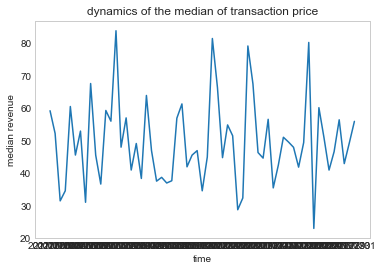

No handles with labels found to put in legend.


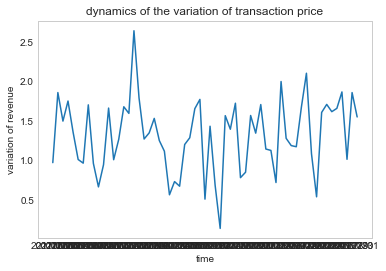

No handles with labels found to put in legend.


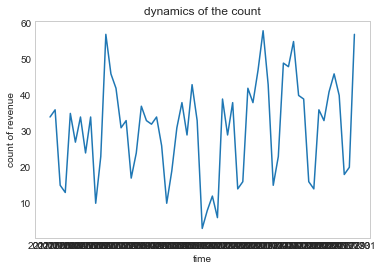

In [8]:
for i in graphs:

	fig = plt.figure()
	ax = plt.axes()
	ax.plot(dates, np.array(i[2]))
	plt.title(i[0])
	plt.grid(which='minor', alpha=1)
	plt.grid(which='major', alpha=1)
	plt.legend(loc='best')
	plt.xlabel("time")
	plt.ylabel(i[1])
	plt.show()
	plt.show()

In [9]:
QUERY_COUNTRY = ("""
with data as (

	select unique_session_id, total_revenue, logtar, country,
	count(total_revenue) over (partition by country) as count,
	avg(total_revenue) over (partition by country) as avg,
	PERCENTILE_CONT(total_revenue, 0.5) OVER(partition by country) as median,
	stddev_samp(total_revenue) over(partition by country) as sko
	from
	(
    select *
from
(
	select * ,
stddev_samp(logtar) over(partition by country) as sko,
avg(logtar) over(partition by country) as avg
from
  (
  SELECT
      CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
      totals.totalTransactionRevenue/1e6 AS total_revenue,
      date, geoNetwork.country as country
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
      _TABLE_SUFFIX BETWEEN '20160601' AND '20170731'
      AND totals.totalTransactionRevenue IS NOT NULL
      AND geoNetwork.country = 'United States'
  ) as source_data
) as before_cut
WHERE abs(logtar - avg) < 3.09*sko
   ) as after_cut

)

    SELECT distinct country,
    count, avg, median, sko
    FROM data
    where count>20
    order by count
		""")

In [10]:
#В процессе
#романовский + стёрджес
QUERY_FOR_DISTRIBUTION = ("""
with data as (
select *,
unnest(array(select generate_series(1::numeric,
							base_characteristics.ceil::numeric,
							1::numeric) as degenerate)) as another_unnest
from
(
select *,
	   over_test_max,
	   over_test_min,
	   over_test,
	   ((over_test_max - over_test_min)/(1+3.5*log(over_test))) as step,
	   ceil((over_test_max-over_test_min)/((over_test_max - over_test_min)/(1+3.5*log(over_test)))) as ceil,
	(
		select sum(num) from (SELECT ROW_NUMBER() OVER() AS num
		FROM UNNEST(
			(SELECT GENERATE_ARRAY(1,
		ceil((over_test_max-over_test_min)/((over_test_max - over_test_min)/(1+3.5*log(over_test))))
			) AS h FROM (SELECT NULL))
			) AS pos) as pos_2
	) as sum_another_teor
from (
	select unique_session_id, total_revenue, logtar, country,
	count(total_revenue) over (partition by country) as count,
	avg(total_revenue) over (partition by country) as avg,
	PERCENTILE_CONT(total_revenue, 0.5) OVER(partition by country) as median,
	stddev_samp(total_revenue) over(partition by country) as sko,
	min(total_revenue) over (partition by country) as over_test_min,
	max(total_revenue) over (partition by country) as over_test_max,
	count(total_revenue) over (partition by country) as over_test
	from
	(
    select *
from
(
	select * ,
stddev_samp(logtar) over(partition by country) as sko,
avg(logtar) over(partition by country) as avg
from
  (
  SELECT
      CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS unique_session_id,
      totals.totalTransactionRevenue/1e6 AS total_revenue,
	  log(totals.totalTransactionRevenue/1e6) as logtar,
      geoNetwork.country as country
  FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
      _TABLE_SUFFIX BETWEEN '20170501' AND '20170731'
      AND totals.totalTransactionRevenue IS NOT NULL
      and geoNetwork.country is not NULL
      and geoNetwork.country = 'United States'
  ) as source_data
) as before_cut
WHERE abs(logtar - avg) < 3.09*sko
   ) as after_cut
) as first_analyze
) as second_analyze
)

select * from data limit 10

""")